# Figure 5 (Segregated I populations)
### This code runs the simulations and reproduces Fig 5B and 5C

In [1]:
from KeyFunctions.TheoryFunctions import *
from KeyFunctions.SimulationFunctions import *

from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.pyplot as plt
import matplotlib as mp

### Default parameters

In [2]:
# Strength and structure of noise
sigE=1; sigI=1; c=0

# 'Diffusion' matrix for the noise term
D_private = np.diag([np.sqrt(1-c)*sigE, np.sqrt(1-c)*sigE, sigI, sigI])
D_shared = np.array([np.sqrt(c)*sigE,np.sqrt(c)*sigE,0, 0])
DMatrix = np.c_[D_private,D_shared]

# Time constants
tau_E=15; tau_I=15
tau = np.array([[tau_E], [tau_E], [tau_I], [tau_I]])

# Connectivity parameters
Wee = 1.15; alpha = 0.15; 
Wii=0.5; Wei=1; Wie=1
beta = 0; gamma = 0; zeta = 0
W = np.block([[Wee, alpha*Wee, -Wei, -beta*Wei],
              [alpha*Wee, Wee, -beta*Wei, -Wei],
              [Wie, gamma*Wie, -Wii, -zeta*Wii],
              [gamma*Wie, Wie, -zeta*Wii, -Wii]])

# Numerics
K = 200 # Discretize 2D parameter space
Cov, Corr, Max_evrp,_ = corrTheory(W, DMatrix)

### Fig 5B
#### Find the corrlation between E1 and E2 as a function of Wei and Wie (two-dimensional parameter sweep)

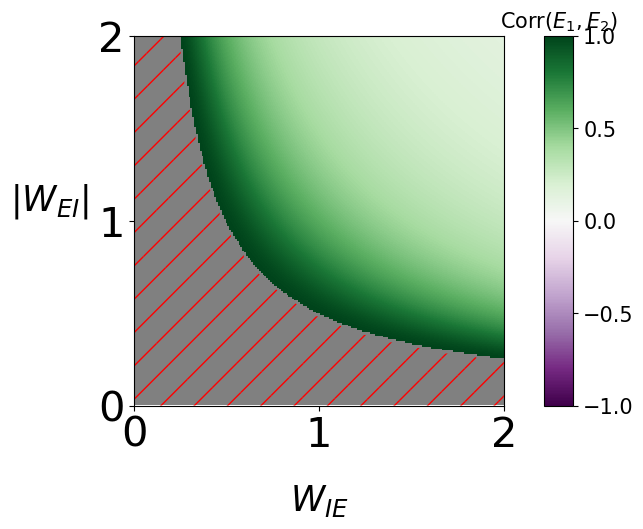

In [3]:
#range of W_EI
Wei_vec = np.linspace(0, 2, K)
Wie_vec = np.linspace(0, 2, K) 

Corrs_12 = np.zeros((K,K))
Covs_12 = np.zeros((K,K))
Max_evrp = np.zeros((K,K))

for i in range(K):
        Wei = Wei_vec[i]
        for j in range(K):
            Wie = Wie_vec[j]
            
            W[0,2] = -Wei # I->E
            W[0,3] = -beta*Wei # I->E
            W[1,3] = -Wei # I->E
            W[1,2] = -beta*Wei # I->E
            W[2,0] = Wie # E->I
            W[2,1] = gamma*Wie # E->I
            W[3,1] = Wie # E->I
            W[3,0] = gamma*Wie # E->I
            
            Cov, Corr, Max_evrp[i,j],_ = corrTheory(W, DMatrix)
            Covs_12[i,j] = Cov[0,1]
            Corrs_12[i,j] = Corr[0,1]

# Plot the results
fig,ax = plt.subplots()
plt.rcParams.update({'hatch.color': 'red'})

cmap = mp.colormaps["PRGn"]
cmap.set_bad(color='gray')

divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='8%', pad=.4)
im = ax.imshow(np.flip(Corrs_12, axis=0), cmap=cmap, vmin=-1, vmax= 1, extent=[0, 2, 0, 2])
cbar=fig.colorbar(im, cax=cax, orientation='vertical')

unstable_eigmask = np.ma.masked_less(Max_evrp,1) 
hatches = ax.contourf(Wei_vec, Wie_vec, unstable_eigmask, extent=[0, 2, 0, 2], hatches='//', alpha=0.)

ax.yaxis.set_ticks([0, 1, 2])
ax.xaxis.set_ticks([0, 1, 2])
ax.xaxis.set_tick_params(labelsize=30)
ax.yaxis.set_tick_params(labelsize=30)
ax.set_xlabel(r'$W_{IE}$', fontsize=25, labelpad=20)
ax.set_ylabel(r'$|W_{EI}|$', rotation=0, fontsize=25, labelpad=35)
cbar.ax.yaxis.set_tick_params(labelsize=15)

cbar.ax.yaxis.set_ticks([-1.0,-0.5, 0, 0.5,1.0])
ax.set_xlim(0,2)
ax.set_ylim(0,2)
plt.title(r'Corr$(E_1,E_2)$', fontsize=15)

plt.show()

### Fig 5C
#### Find the corrlation between E1 and E2 as a function of cross connections (e.g., E1->I1)

In [4]:
Wee = 1.15; alpha = 0.15; Wii=0.5; Wei=1; Wie=1
beta = 0; gamma = 0; zeta = 0
W = np.block([[Wee, alpha*Wee, -Wei, -beta*Wei],
              [alpha*Wee, Wee, -beta*Wei, -Wei],
              [Wie, gamma*Wie, -Wii, -zeta*Wii],
              [gamma*Wie, Wie, -zeta*Wii, -Wii]])


Corrs_12 = np.zeros((K,3))
PR = np.zeros((K,3))
PR2 = np.zeros((K,3))
crossConnection = np.linspace(0,1,K)

# Turning on cross I connections
for i in range(K):            
    W[2,3] = -crossConnection[i]*Wii # I->I
    W[3,2] = -crossConnection[i]*Wii # I->I

    Cov, Corr, _,_ = corrTheory(W, DMatrix)
    Corrs_12[i,0] = Corr[0,1]
    
    subMatrix = Cov[0:2,0:2]
    CovSquared = Cov@Cov
    subMatrixSquared = CovSquared[0:2,0:2]
    if ~np.isnan(Cov[0,0]):
        PR[i,0] = sum(np.linalg.eigvals(Cov))**2/sum(np.linalg.eigvals(Cov@Cov))
        PR2[i,0] = sum(np.linalg.eigvals(subMatrix))**2/sum(np.linalg.eigvals(subMatrixSquared))

W[2,3] = 0; W[3,2] = 0
# Turning on cross I->E connections
for i in range(K): 
    W[0,3] = -crossConnection[i]*Wei # I->E
    W[1,2] = -crossConnection[i]*Wei # I->E

    Cov, Corr, _,_ = corrTheory(W, DMatrix)
    Corrs_12[i,1] = Corr[0,1]
    
    subMatrix = Cov[0:2,0:2]
    CovSquared = Cov@Cov
    subMatrixSquared = CovSquared[0:2,0:2]
    if ~np.isnan(Cov[0,0]):
        PR[i,1] = sum(np.linalg.eigvals(Cov))**2/sum(np.linalg.eigvals(Cov@Cov))
        PR2[i,1] = sum(np.linalg.eigvals(subMatrix))**2/sum(np.linalg.eigvals(subMatrixSquared))
    
W[0,3] = 0; W[1,2] = 0
# Turning on cross E->I connections
for i in range(K): 
    W[2,1] = crossConnection[i]*Wie # E->I
    W[3,0] = crossConnection[i]*Wie # E->I

    Cov, Corr, _,_ = corrTheory(W, DMatrix)
    Corrs_12[i,2] = Corr[0,1]
    
    # Participation ratio calculation
    subMatrix = Cov[0:2,0:2]
    CovSquared = Cov@Cov
    subMatrixSquared = CovSquared[0:2,0:2]
    if ~np.isnan(Cov[0,0]):
        PR[i,2] = sum(np.linalg.eigvals(Cov))**2/sum(np.linalg.eigvals(Cov@Cov))
        PR2[i,2] = sum(np.linalg.eigvals(subMatrix))**2/sum(np.linalg.eigvals(subMatrixSquared))


### Corr plots has a function of cross-connection strength 

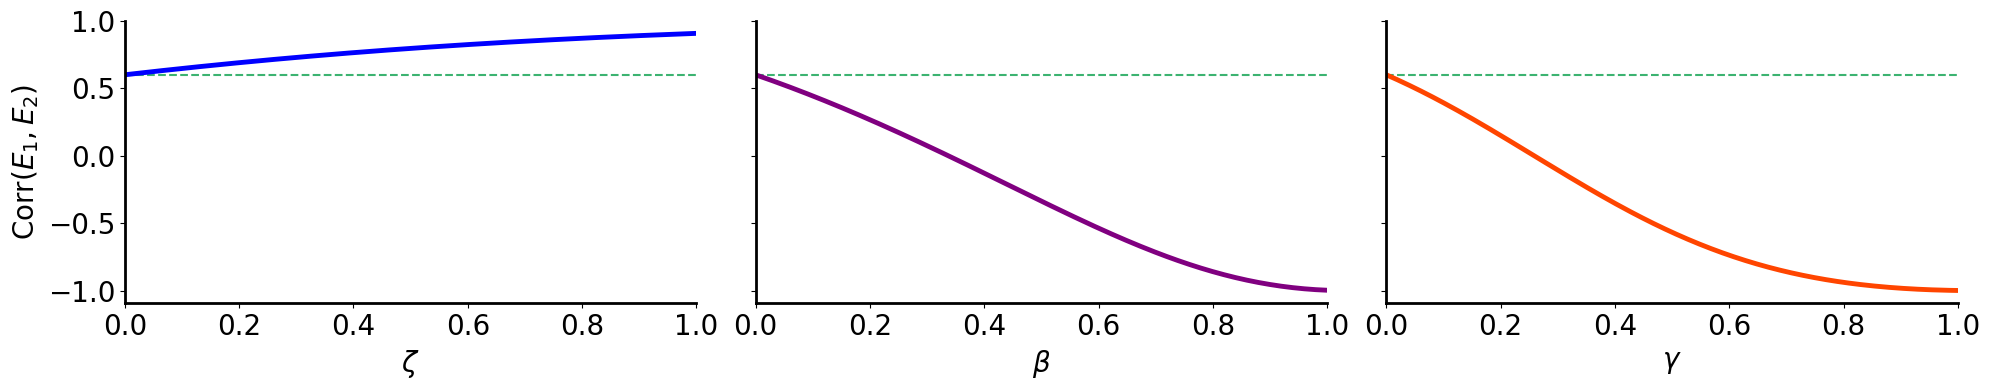

In [5]:
fig, axs = plt.subplots(figsize=(20,4),nrows=1, ncols=3, sharey=True)

for i in range(3):
    axs[i].spines['left'].set_linewidth(2)
    axs[i].spines['bottom'].set_linewidth(2)
    axs[i].spines['right'].set_color('none')
    axs[i].spines['top'].set_color('none')
    axs[i].xaxis.set_tick_params(labelsize=20)
    axs[i].yaxis.set_tick_params(labelsize=20)
    axs[i].set_xlim(0,1) 
    axs[i].axhline(y=Corrs_12[0,0], linestyle='--', color='mediumseagreen')

        
axs[0].plot(crossConnection, Corrs_12[:,0], linewidth=3.5, color='blue', label=r'$\zeta$')
axs[0].set_xlabel(r'$\zeta$', fontsize=20, labelpad=5)
axs[0].set_ylabel(r'Corr$(E_1,E_2)$', fontsize=20, labelpad=5)


axs[1].plot(crossConnection, Corrs_12[:,1], linewidth=3.5, color='purple', label=r'$\beta$')
axs[1].set_xlabel(r'$\beta$', fontsize=20, labelpad=5)
axs[1].set_xlim(0,1)

axs[2].plot(crossConnection, Corrs_12[:,2], linewidth=3.5, color='orangered', label=r'$\gamma$')
axs[2].set_xlabel(r'$\gamma$', fontsize=20, labelpad=5)
axs[2].set_xlim(0,1)
       
plt.tight_layout()
plt.show()    